# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [2]:
data_dir = '/tmp'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Extracting mnist: 100%|██████████| 60.0K/60.0K [00:11<00:00, 5.39KFile/s]


Extracting celeba...


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

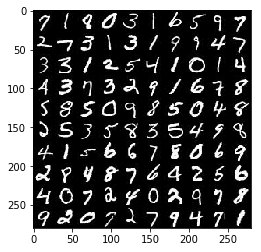

In [3]:
show_n_images = 100

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

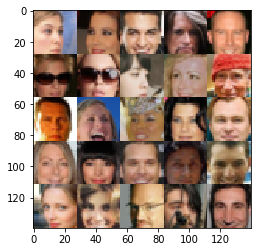

In [4]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [5]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.3.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [6]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real= tf.placeholder(tf.float32, shape=(None, image_width,image_height,image_channels), name="input_real")
    input_z= tf.placeholder(tf.float32, shape=(None, z_dim), name="input_z")
    learning_rate= tf.placeholder(tf.float32, name="learning_rate", shape=())

    return input_real, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [7]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope("discriminator", reuse=reuse):
        # Input layer is 28x28x3
        conv_1= tf.layers.conv2d(images, 64,5,strides=2, padding="same",activation=None,kernel_initializer=tf.contrib.layers.xavier_initializer())
        relu_1= tf.maximum(0.1 * conv_1, conv_1)
        # 14*14*64
        
        conv_2= tf.layers.conv2d(relu_1, 128,5,strides=2, padding="same",activation=None,kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn2 = tf.layers.batch_normalization(conv_2, training=True)
        relu_2= tf.maximum(0.1 * bn2, bn2)
        relu_2=tf.nn.dropout(relu_2, keep_prob=0.9)
        # 7*7*128
        
        conv_3= tf.layers.conv2d(relu_2, 256,5,strides=2, padding="same",activation=None,kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn3 = tf.layers.batch_normalization(conv_3, training=True)
        relu_3= tf.maximum(0.1 * bn3, bn3)
        relu_3=tf.nn.dropout(relu_3, keep_prob=0.9)
        # 4*4*256
        
        # Flatten it
        flat = tf.reshape(relu_3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        

    return (out, logits)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [8]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope("generator", reuse= not is_train):
        dense_1= tf.layers.dense(z, 7*7*512)
        # Reshape it to start the convolutional stack
        dense_1 = tf.reshape(dense_1, (-1, 7, 7, 512))
        dense_1 = tf.layers.batch_normalization(dense_1, training=is_train)
        dense_1 = tf.maximum(0.1 * dense_1, dense_1)
        # 7x7x512
        
        convt_2= tf.layers.conv2d_transpose(dense_1, 256, 5, strides=2, padding="same",activation=None,kernel_initializer=tf.contrib.layers.xavier_initializer())
        convt_2 = tf.layers.batch_normalization(convt_2, training=is_train)
        convt_2 = tf.maximum(0.1 * convt_2, convt_2)
        convt_2 = tf.nn.dropout(convt_2, keep_prob=0.9)
        # 14x14x256 now
        
        
        convt_3 = tf.layers.conv2d_transpose(convt_2, 128, 5, strides=2, padding='same',activation=None,kernel_initializer=tf.contrib.layers.xavier_initializer())
        convt_3 = tf.layers.batch_normalization(convt_3, training=is_train)
        convt_3 = tf.maximum(0.1 * convt_3, convt_3)
        convt_3 = tf.nn.dropout(convt_3, keep_prob=0.9)
        #28x28x128 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(convt_3, out_channel_dim, 5, strides=1, padding='same',activation=None,kernel_initializer=tf.contrib.layers.xavier_initializer())
        # 28x28x3 now
        
        out = tf.tanh(logits)
        
        
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [9]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    gen_output= generator(input_z, out_channel_dim)
    real_out, real_logits = discriminator(input_real, reuse=False)
    fake_out, fake_logits = discriminator(gen_output, reuse=True)
    
    d_real_loss= tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=real_logits, labels=tf.ones_like(real_out)*0.9))
    
    d_fake_loss= tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=fake_logits, labels=tf.zeros_like(fake_out)))
    
    discriminator_loss = d_real_loss + d_fake_loss
    
    generator_loss =tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=fake_logits, labels=tf.ones_like(fake_out)))
    return (discriminator_loss, generator_loss)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [10]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    all_train_var=tf.trainable_variables()
    gen_var=[ var for var in all_train_var if var.name.startswith("generator")]
    disc_var=[ var for var in all_train_var if var.name.startswith("discriminator")]
    
    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        disc_opti = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1). minimize(d_loss, var_list= disc_var)
        gen_opti = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1). minimize(g_loss, var_list= gen_var)
    return (disc_opti, gen_opti)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [11]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [12]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    _, image_width, image_height, image_channels = data_shape
    input_real, input_z, lear_rate = model_inputs(image_width, image_height, image_channels, z_dim)
    discriminator_loss, generator_loss = model_loss(input_real, input_z, image_channels)
    disc_opt, gen_opt = model_opt(discriminator_loss, generator_loss, learning_rate, beta1)
    
    saver = tf.train.Saver()
    steps = 0
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                batch_images *= 2.0
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                 # Run optimizers
                _ = sess.run(disc_opt, feed_dict={input_real: batch_images, input_z: batch_z,lear_rate: learning_rate})
                _ = sess.run(gen_opt, feed_dict={input_z: batch_z, input_real: batch_images,lear_rate: learning_rate})
    
                if steps == 1:
                    print('initial image')
                    show_generator_output(sess, 25, input_z, image_channels, data_image_mode)
                    
                if steps % 10 == 0:
                    # print the losses every 100 steps
                    train_loss_d = discriminator_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = generator_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}..., step {}".format(epoch_i+1, epochs, steps),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                if steps % 100 == 0:
                    show_generator_output(sess, 25, input_z, image_channels, data_image_mode)
                    
        saver.save(sess, './generator.ckpt')

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

initial image


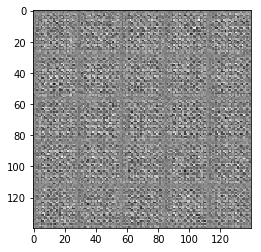

Epoch 1/1..., step 10 Discriminator Loss: 0.4403... Generator Loss: 2.8129
Epoch 1/1..., step 20 Discriminator Loss: 0.3837... Generator Loss: 4.8675
Epoch 1/1..., step 30 Discriminator Loss: 0.3650... Generator Loss: 4.5236
Epoch 1/1..., step 40 Discriminator Loss: 0.3702... Generator Loss: 4.4304
Epoch 1/1..., step 50 Discriminator Loss: 0.5778... Generator Loss: 1.7648
Epoch 1/1..., step 60 Discriminator Loss: 0.5480... Generator Loss: 3.6262
Epoch 1/1..., step 70 Discriminator Loss: 0.4026... Generator Loss: 4.6656
Epoch 1/1..., step 80 Discriminator Loss: 3.4270... Generator Loss: 10.4250
Epoch 1/1..., step 90 Discriminator Loss: 0.8729... Generator Loss: 1.4330
Epoch 1/1..., step 100 Discriminator Loss: 0.9707... Generator Loss: 1.3307


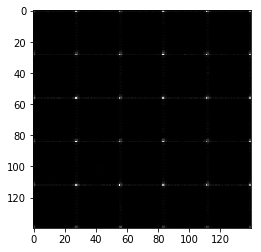

Epoch 1/1..., step 110 Discriminator Loss: 1.2199... Generator Loss: 0.8126
Epoch 1/1..., step 120 Discriminator Loss: 1.1967... Generator Loss: 0.9220
Epoch 1/1..., step 130 Discriminator Loss: 1.1119... Generator Loss: 1.1948
Epoch 1/1..., step 140 Discriminator Loss: 0.9874... Generator Loss: 1.3476
Epoch 1/1..., step 150 Discriminator Loss: 1.2739... Generator Loss: 0.9321
Epoch 1/1..., step 160 Discriminator Loss: 1.2512... Generator Loss: 0.7846
Epoch 1/1..., step 170 Discriminator Loss: 1.5167... Generator Loss: 1.3340
Epoch 1/1..., step 180 Discriminator Loss: 1.1751... Generator Loss: 1.7110
Epoch 1/1..., step 190 Discriminator Loss: 1.4638... Generator Loss: 0.6367
Epoch 1/1..., step 200 Discriminator Loss: 1.0423... Generator Loss: 1.1336


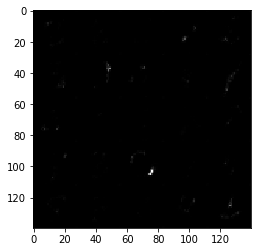

Epoch 1/1..., step 210 Discriminator Loss: 1.1647... Generator Loss: 0.8997
Epoch 1/1..., step 220 Discriminator Loss: 1.1065... Generator Loss: 1.2137
Epoch 1/1..., step 230 Discriminator Loss: 0.9802... Generator Loss: 1.3829
Epoch 1/1..., step 240 Discriminator Loss: 1.1036... Generator Loss: 1.0360
Epoch 1/1..., step 250 Discriminator Loss: 1.1883... Generator Loss: 0.8519
Epoch 1/1..., step 260 Discriminator Loss: 1.3670... Generator Loss: 0.5563
Epoch 1/1..., step 270 Discriminator Loss: 1.0870... Generator Loss: 1.6828
Epoch 1/1..., step 280 Discriminator Loss: 1.2716... Generator Loss: 0.6582
Epoch 1/1..., step 290 Discriminator Loss: 1.0191... Generator Loss: 1.5446
Epoch 1/1..., step 300 Discriminator Loss: 1.1608... Generator Loss: 1.5035


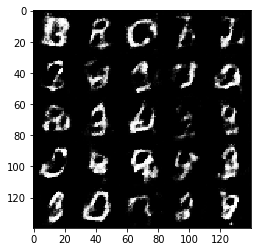

Epoch 1/1..., step 310 Discriminator Loss: 1.2040... Generator Loss: 0.7063
Epoch 1/1..., step 320 Discriminator Loss: 1.2000... Generator Loss: 0.7828
Epoch 1/1..., step 330 Discriminator Loss: 1.2327... Generator Loss: 0.7039
Epoch 1/1..., step 340 Discriminator Loss: 1.0058... Generator Loss: 1.4338
Epoch 1/1..., step 350 Discriminator Loss: 1.4094... Generator Loss: 0.5795
Epoch 1/1..., step 360 Discriminator Loss: 0.9814... Generator Loss: 1.2983
Epoch 1/1..., step 370 Discriminator Loss: 1.1384... Generator Loss: 0.9750
Epoch 1/1..., step 380 Discriminator Loss: 1.0667... Generator Loss: 1.3878
Epoch 1/1..., step 390 Discriminator Loss: 1.0286... Generator Loss: 1.1756
Epoch 1/1..., step 400 Discriminator Loss: 1.5862... Generator Loss: 0.3957


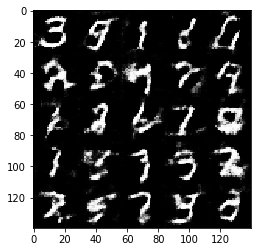

Epoch 1/1..., step 410 Discriminator Loss: 0.9958... Generator Loss: 1.4777
Epoch 1/1..., step 420 Discriminator Loss: 1.1474... Generator Loss: 0.9101
Epoch 1/1..., step 430 Discriminator Loss: 1.1086... Generator Loss: 1.4332
Epoch 1/1..., step 440 Discriminator Loss: 1.0699... Generator Loss: 1.5971
Epoch 1/1..., step 450 Discriminator Loss: 1.1935... Generator Loss: 0.9563
Epoch 1/1..., step 460 Discriminator Loss: 1.1763... Generator Loss: 0.8841
Epoch 1/1..., step 470 Discriminator Loss: 1.2231... Generator Loss: 0.7121
Epoch 1/1..., step 480 Discriminator Loss: 1.2036... Generator Loss: 0.7282
Epoch 1/1..., step 490 Discriminator Loss: 1.2045... Generator Loss: 0.8459
Epoch 1/1..., step 500 Discriminator Loss: 1.1136... Generator Loss: 1.0915


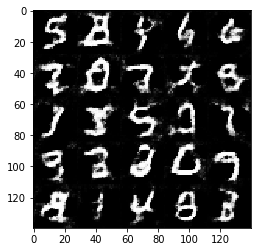

Epoch 1/1..., step 510 Discriminator Loss: 1.2129... Generator Loss: 0.8720
Epoch 1/1..., step 520 Discriminator Loss: 1.3252... Generator Loss: 0.5808
Epoch 1/1..., step 530 Discriminator Loss: 1.1782... Generator Loss: 0.8755
Epoch 1/1..., step 540 Discriminator Loss: 1.3551... Generator Loss: 0.5578
Epoch 1/1..., step 550 Discriminator Loss: 1.0809... Generator Loss: 1.3001
Epoch 1/1..., step 560 Discriminator Loss: 1.0610... Generator Loss: 1.0759
Epoch 1/1..., step 570 Discriminator Loss: 1.0905... Generator Loss: 1.2657
Epoch 1/1..., step 580 Discriminator Loss: 1.1294... Generator Loss: 0.9170
Epoch 1/1..., step 590 Discriminator Loss: 1.1012... Generator Loss: 1.7519
Epoch 1/1..., step 600 Discriminator Loss: 1.0822... Generator Loss: 1.4178


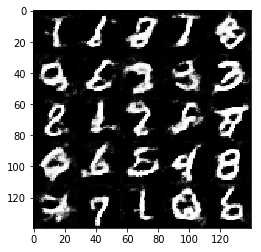

Epoch 1/1..., step 610 Discriminator Loss: 1.1385... Generator Loss: 0.9379
Epoch 1/1..., step 620 Discriminator Loss: 1.0232... Generator Loss: 1.4107
Epoch 1/1..., step 630 Discriminator Loss: 1.1140... Generator Loss: 0.9596
Epoch 1/1..., step 640 Discriminator Loss: 1.2764... Generator Loss: 0.7084
Epoch 1/1..., step 650 Discriminator Loss: 0.9910... Generator Loss: 1.0815
Epoch 1/1..., step 660 Discriminator Loss: 0.9727... Generator Loss: 1.2530
Epoch 1/1..., step 670 Discriminator Loss: 1.0618... Generator Loss: 0.9708
Epoch 1/1..., step 680 Discriminator Loss: 1.0436... Generator Loss: 1.4506
Epoch 1/1..., step 690 Discriminator Loss: 1.2574... Generator Loss: 1.8381
Epoch 1/1..., step 700 Discriminator Loss: 1.0203... Generator Loss: 1.5494


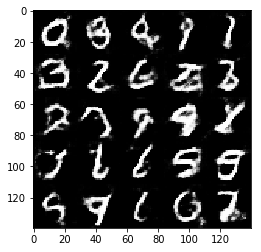

Epoch 1/1..., step 710 Discriminator Loss: 1.0166... Generator Loss: 1.3946
Epoch 1/1..., step 720 Discriminator Loss: 1.1482... Generator Loss: 0.9315
Epoch 1/1..., step 730 Discriminator Loss: 1.4546... Generator Loss: 0.5407
Epoch 1/1..., step 740 Discriminator Loss: 1.0770... Generator Loss: 0.8992
Epoch 1/1..., step 750 Discriminator Loss: 1.0274... Generator Loss: 1.1519
Epoch 1/1..., step 760 Discriminator Loss: 1.0104... Generator Loss: 1.4540
Epoch 1/1..., step 770 Discriminator Loss: 1.0306... Generator Loss: 1.1580
Epoch 1/1..., step 780 Discriminator Loss: 1.1354... Generator Loss: 0.8998
Epoch 1/1..., step 790 Discriminator Loss: 1.0410... Generator Loss: 1.0836
Epoch 1/1..., step 800 Discriminator Loss: 1.1510... Generator Loss: 0.7531


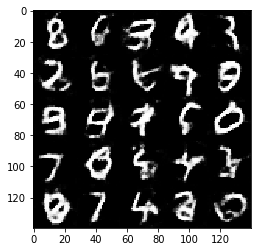

Epoch 1/1..., step 810 Discriminator Loss: 0.9644... Generator Loss: 1.1311
Epoch 1/1..., step 820 Discriminator Loss: 1.1602... Generator Loss: 2.0433
Epoch 1/1..., step 830 Discriminator Loss: 1.0112... Generator Loss: 1.1371
Epoch 1/1..., step 840 Discriminator Loss: 0.9009... Generator Loss: 1.3855
Epoch 1/1..., step 850 Discriminator Loss: 1.6097... Generator Loss: 0.4354
Epoch 1/1..., step 860 Discriminator Loss: 0.9539... Generator Loss: 1.3597
Epoch 1/1..., step 870 Discriminator Loss: 1.0220... Generator Loss: 1.5632
Epoch 1/1..., step 880 Discriminator Loss: 1.0645... Generator Loss: 0.9548
Epoch 1/1..., step 890 Discriminator Loss: 1.1155... Generator Loss: 0.9034
Epoch 1/1..., step 900 Discriminator Loss: 1.0348... Generator Loss: 1.0184


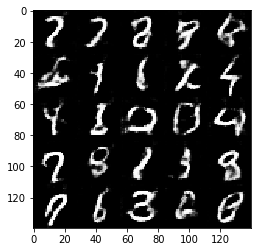

Epoch 1/1..., step 910 Discriminator Loss: 1.3611... Generator Loss: 0.6097
Epoch 1/1..., step 920 Discriminator Loss: 1.2392... Generator Loss: 0.6352
Epoch 1/1..., step 930 Discriminator Loss: 1.0523... Generator Loss: 0.9879


In [13]:
batch_size = 64
z_dim = 128
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

initial image


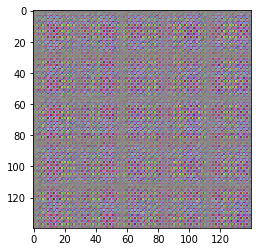

Epoch 1/1..., step 10 Discriminator Loss: 0.4038... Generator Loss: 4.1505
Epoch 1/1..., step 20 Discriminator Loss: 0.4321... Generator Loss: 3.1330
Epoch 1/1..., step 30 Discriminator Loss: 0.3947... Generator Loss: 5.7652
Epoch 1/1..., step 40 Discriminator Loss: 1.3883... Generator Loss: 10.5987
Epoch 1/1..., step 50 Discriminator Loss: 0.6756... Generator Loss: 2.4363
Epoch 1/1..., step 60 Discriminator Loss: 1.3275... Generator Loss: 5.3277
Epoch 1/1..., step 70 Discriminator Loss: 0.7576... Generator Loss: 1.8990
Epoch 1/1..., step 80 Discriminator Loss: 1.2404... Generator Loss: 0.7567
Epoch 1/1..., step 90 Discriminator Loss: 0.4560... Generator Loss: 3.9196
Epoch 1/1..., step 100 Discriminator Loss: 0.4314... Generator Loss: 3.8426


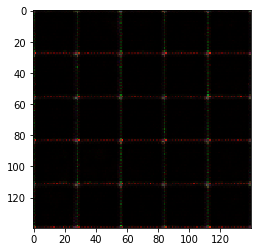

Epoch 1/1..., step 110 Discriminator Loss: 0.4389... Generator Loss: 3.1250
Epoch 1/1..., step 120 Discriminator Loss: 3.2630... Generator Loss: 0.1455
Epoch 1/1..., step 130 Discriminator Loss: 0.4066... Generator Loss: 5.5969
Epoch 1/1..., step 140 Discriminator Loss: 2.6944... Generator Loss: 9.3466
Epoch 1/1..., step 150 Discriminator Loss: 0.4161... Generator Loss: 5.2898
Epoch 1/1..., step 160 Discriminator Loss: 0.6803... Generator Loss: 2.1338
Epoch 1/1..., step 170 Discriminator Loss: 1.6150... Generator Loss: 0.4732
Epoch 1/1..., step 180 Discriminator Loss: 1.6149... Generator Loss: 0.4533
Epoch 1/1..., step 190 Discriminator Loss: 0.8900... Generator Loss: 1.3334
Epoch 1/1..., step 200 Discriminator Loss: 1.0144... Generator Loss: 2.0254


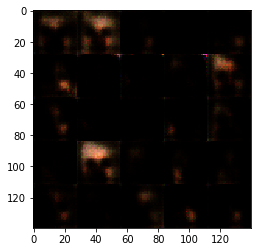

Epoch 1/1..., step 210 Discriminator Loss: 0.8400... Generator Loss: 2.1223
Epoch 1/1..., step 220 Discriminator Loss: 0.9187... Generator Loss: 2.8328
Epoch 1/1..., step 230 Discriminator Loss: 1.2361... Generator Loss: 0.7265
Epoch 1/1..., step 240 Discriminator Loss: 1.1371... Generator Loss: 3.5507
Epoch 1/1..., step 250 Discriminator Loss: 0.9629... Generator Loss: 1.5058
Epoch 1/1..., step 260 Discriminator Loss: 0.8237... Generator Loss: 1.2100
Epoch 1/1..., step 270 Discriminator Loss: 1.0812... Generator Loss: 1.0542
Epoch 1/1..., step 280 Discriminator Loss: 0.8463... Generator Loss: 1.6259
Epoch 1/1..., step 290 Discriminator Loss: 0.8800... Generator Loss: 1.1721
Epoch 1/1..., step 300 Discriminator Loss: 0.9803... Generator Loss: 0.9756


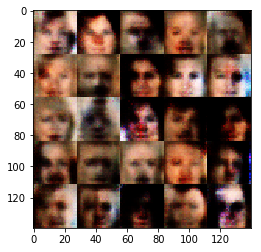

Epoch 1/1..., step 310 Discriminator Loss: 1.0118... Generator Loss: 0.9144
Epoch 1/1..., step 320 Discriminator Loss: 2.3712... Generator Loss: 4.3934
Epoch 1/1..., step 330 Discriminator Loss: 1.1824... Generator Loss: 0.8726
Epoch 1/1..., step 340 Discriminator Loss: 1.0506... Generator Loss: 0.9109
Epoch 1/1..., step 350 Discriminator Loss: 1.0267... Generator Loss: 1.1731
Epoch 1/1..., step 360 Discriminator Loss: 1.0067... Generator Loss: 0.8787
Epoch 1/1..., step 370 Discriminator Loss: 1.6166... Generator Loss: 0.4253
Epoch 1/1..., step 380 Discriminator Loss: 1.1979... Generator Loss: 0.7031
Epoch 1/1..., step 390 Discriminator Loss: 1.0335... Generator Loss: 1.3154
Epoch 1/1..., step 400 Discriminator Loss: 0.9738... Generator Loss: 1.1505


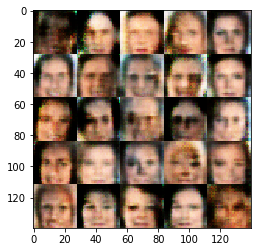

Epoch 1/1..., step 410 Discriminator Loss: 1.0246... Generator Loss: 0.9408
Epoch 1/1..., step 420 Discriminator Loss: 1.0444... Generator Loss: 1.4278
Epoch 1/1..., step 430 Discriminator Loss: 1.6210... Generator Loss: 2.4996
Epoch 1/1..., step 440 Discriminator Loss: 2.2578... Generator Loss: 0.2164
Epoch 1/1..., step 450 Discriminator Loss: 1.2094... Generator Loss: 0.6625
Epoch 1/1..., step 460 Discriminator Loss: 2.7163... Generator Loss: 3.5348
Epoch 1/1..., step 470 Discriminator Loss: 1.1240... Generator Loss: 1.0418
Epoch 1/1..., step 480 Discriminator Loss: 1.2400... Generator Loss: 2.3667
Epoch 1/1..., step 490 Discriminator Loss: 1.4298... Generator Loss: 2.6634
Epoch 1/1..., step 500 Discriminator Loss: 1.2283... Generator Loss: 2.0410


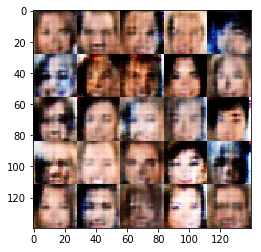

Epoch 1/1..., step 510 Discriminator Loss: 1.4747... Generator Loss: 2.6137
Epoch 1/1..., step 520 Discriminator Loss: 1.8499... Generator Loss: 0.3277
Epoch 1/1..., step 530 Discriminator Loss: 0.9306... Generator Loss: 0.9957
Epoch 1/1..., step 540 Discriminator Loss: 1.2606... Generator Loss: 1.0886
Epoch 1/1..., step 550 Discriminator Loss: 1.5401... Generator Loss: 0.4651
Epoch 1/1..., step 560 Discriminator Loss: 1.0874... Generator Loss: 0.9602
Epoch 1/1..., step 570 Discriminator Loss: 1.0839... Generator Loss: 1.5246
Epoch 1/1..., step 580 Discriminator Loss: 1.2556... Generator Loss: 0.6471
Epoch 1/1..., step 590 Discriminator Loss: 1.5945... Generator Loss: 0.4941
Epoch 1/1..., step 600 Discriminator Loss: 1.0030... Generator Loss: 1.5192


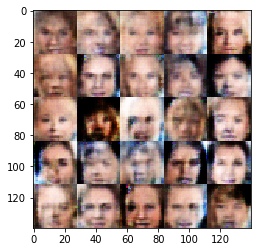

Epoch 1/1..., step 610 Discriminator Loss: 0.9166... Generator Loss: 1.2357
Epoch 1/1..., step 620 Discriminator Loss: 1.1183... Generator Loss: 0.7920
Epoch 1/1..., step 630 Discriminator Loss: 1.1700... Generator Loss: 0.9040
Epoch 1/1..., step 640 Discriminator Loss: 1.1627... Generator Loss: 1.0675
Epoch 1/1..., step 650 Discriminator Loss: 1.2574... Generator Loss: 0.7681
Epoch 1/1..., step 660 Discriminator Loss: 1.0856... Generator Loss: 0.8865
Epoch 1/1..., step 670 Discriminator Loss: 1.1945... Generator Loss: 0.7247
Epoch 1/1..., step 680 Discriminator Loss: 1.3828... Generator Loss: 0.6043
Epoch 1/1..., step 690 Discriminator Loss: 1.1421... Generator Loss: 0.9903
Epoch 1/1..., step 700 Discriminator Loss: 1.2373... Generator Loss: 0.6728


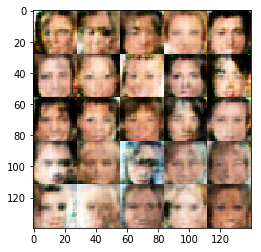

Epoch 1/1..., step 710 Discriminator Loss: 1.0485... Generator Loss: 1.3852
Epoch 1/1..., step 720 Discriminator Loss: 1.3423... Generator Loss: 1.0567
Epoch 1/1..., step 730 Discriminator Loss: 1.2193... Generator Loss: 0.6477
Epoch 1/1..., step 740 Discriminator Loss: 1.4403... Generator Loss: 0.6304
Epoch 1/1..., step 750 Discriminator Loss: 1.3075... Generator Loss: 0.6090
Epoch 1/1..., step 760 Discriminator Loss: 1.4979... Generator Loss: 0.4897
Epoch 1/1..., step 770 Discriminator Loss: 1.3042... Generator Loss: 1.1598
Epoch 1/1..., step 780 Discriminator Loss: 1.1209... Generator Loss: 1.1462
Epoch 1/1..., step 790 Discriminator Loss: 1.2552... Generator Loss: 1.3901
Epoch 1/1..., step 800 Discriminator Loss: 1.2658... Generator Loss: 0.7026


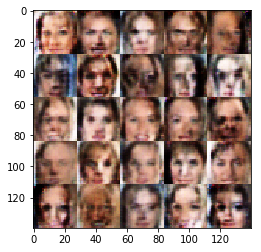

Epoch 1/1..., step 810 Discriminator Loss: 1.3138... Generator Loss: 1.0256
Epoch 1/1..., step 820 Discriminator Loss: 1.3612... Generator Loss: 1.1053
Epoch 1/1..., step 830 Discriminator Loss: 1.3436... Generator Loss: 1.3925
Epoch 1/1..., step 840 Discriminator Loss: 1.1933... Generator Loss: 0.8804
Epoch 1/1..., step 850 Discriminator Loss: 1.2941... Generator Loss: 0.9986
Epoch 1/1..., step 860 Discriminator Loss: 1.2720... Generator Loss: 0.8902
Epoch 1/1..., step 870 Discriminator Loss: 1.6018... Generator Loss: 0.4120
Epoch 1/1..., step 880 Discriminator Loss: 1.3545... Generator Loss: 0.8697
Epoch 1/1..., step 890 Discriminator Loss: 1.2248... Generator Loss: 0.7856
Epoch 1/1..., step 900 Discriminator Loss: 1.2224... Generator Loss: 0.7825


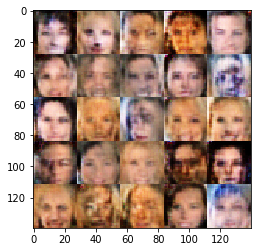

Epoch 1/1..., step 910 Discriminator Loss: 1.2488... Generator Loss: 1.0213
Epoch 1/1..., step 920 Discriminator Loss: 1.2736... Generator Loss: 0.8229
Epoch 1/1..., step 930 Discriminator Loss: 1.4722... Generator Loss: 1.1061
Epoch 1/1..., step 940 Discriminator Loss: 1.1367... Generator Loss: 0.8116
Epoch 1/1..., step 950 Discriminator Loss: 1.3764... Generator Loss: 0.8721
Epoch 1/1..., step 960 Discriminator Loss: 1.4023... Generator Loss: 0.8319
Epoch 1/1..., step 970 Discriminator Loss: 1.6670... Generator Loss: 1.9864
Epoch 1/1..., step 980 Discriminator Loss: 1.1304... Generator Loss: 0.9547
Epoch 1/1..., step 990 Discriminator Loss: 1.4109... Generator Loss: 0.5381
Epoch 1/1..., step 1000 Discriminator Loss: 1.3291... Generator Loss: 0.8241


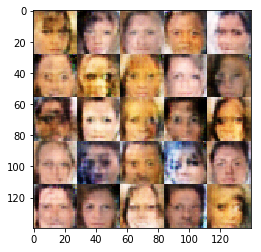

Epoch 1/1..., step 1010 Discriminator Loss: 1.3562... Generator Loss: 0.7459
Epoch 1/1..., step 1020 Discriminator Loss: 1.4154... Generator Loss: 0.5713
Epoch 1/1..., step 1030 Discriminator Loss: 1.2750... Generator Loss: 1.1694
Epoch 1/1..., step 1040 Discriminator Loss: 1.1437... Generator Loss: 0.7813
Epoch 1/1..., step 1050 Discriminator Loss: 1.1650... Generator Loss: 0.9587
Epoch 1/1..., step 1060 Discriminator Loss: 1.6838... Generator Loss: 0.4024
Epoch 1/1..., step 1070 Discriminator Loss: 1.3533... Generator Loss: 0.7161
Epoch 1/1..., step 1080 Discriminator Loss: 1.5163... Generator Loss: 1.4685
Epoch 1/1..., step 1090 Discriminator Loss: 1.1578... Generator Loss: 0.9547
Epoch 1/1..., step 1100 Discriminator Loss: 1.2920... Generator Loss: 1.1804


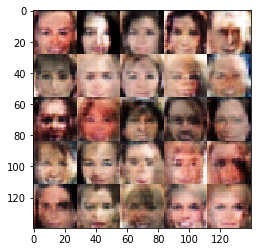

Epoch 1/1..., step 1110 Discriminator Loss: 1.5217... Generator Loss: 0.6213
Epoch 1/1..., step 1120 Discriminator Loss: 1.3902... Generator Loss: 0.9269
Epoch 1/1..., step 1130 Discriminator Loss: 1.1391... Generator Loss: 0.9287
Epoch 1/1..., step 1140 Discriminator Loss: 1.3845... Generator Loss: 0.9864
Epoch 1/1..., step 1150 Discriminator Loss: 1.2571... Generator Loss: 0.7839
Epoch 1/1..., step 1160 Discriminator Loss: 1.1841... Generator Loss: 0.9927
Epoch 1/1..., step 1170 Discriminator Loss: 1.2518... Generator Loss: 0.9041
Epoch 1/1..., step 1180 Discriminator Loss: 1.3169... Generator Loss: 0.5312
Epoch 1/1..., step 1190 Discriminator Loss: 1.4871... Generator Loss: 0.6391
Epoch 1/1..., step 1200 Discriminator Loss: 1.3264... Generator Loss: 0.7790


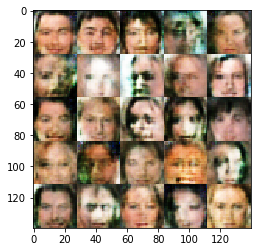

Epoch 1/1..., step 1210 Discriminator Loss: 1.3002... Generator Loss: 1.0779
Epoch 1/1..., step 1220 Discriminator Loss: 1.4115... Generator Loss: 0.7769
Epoch 1/1..., step 1230 Discriminator Loss: 1.1888... Generator Loss: 1.0921
Epoch 1/1..., step 1240 Discriminator Loss: 1.4099... Generator Loss: 0.6298
Epoch 1/1..., step 1250 Discriminator Loss: 1.3024... Generator Loss: 0.7618
Epoch 1/1..., step 1260 Discriminator Loss: 1.3267... Generator Loss: 0.9684
Epoch 1/1..., step 1270 Discriminator Loss: 1.4120... Generator Loss: 0.8940
Epoch 1/1..., step 1280 Discriminator Loss: 1.3471... Generator Loss: 0.7707
Epoch 1/1..., step 1290 Discriminator Loss: 1.2836... Generator Loss: 0.7385
Epoch 1/1..., step 1300 Discriminator Loss: 1.2090... Generator Loss: 1.0166


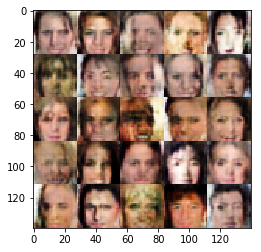

Epoch 1/1..., step 1310 Discriminator Loss: 1.3630... Generator Loss: 0.9942
Epoch 1/1..., step 1320 Discriminator Loss: 1.4968... Generator Loss: 0.6251
Epoch 1/1..., step 1330 Discriminator Loss: 1.1463... Generator Loss: 1.0442
Epoch 1/1..., step 1340 Discriminator Loss: 1.4358... Generator Loss: 0.9177
Epoch 1/1..., step 1350 Discriminator Loss: 1.4360... Generator Loss: 0.8302
Epoch 1/1..., step 1360 Discriminator Loss: 1.3592... Generator Loss: 0.8858
Epoch 1/1..., step 1370 Discriminator Loss: 1.3587... Generator Loss: 0.7393
Epoch 1/1..., step 1380 Discriminator Loss: 1.3318... Generator Loss: 0.7653
Epoch 1/1..., step 1390 Discriminator Loss: 1.3380... Generator Loss: 0.8639
Epoch 1/1..., step 1400 Discriminator Loss: 1.2961... Generator Loss: 0.9800


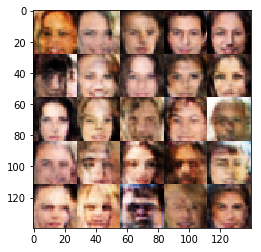

Epoch 1/1..., step 1410 Discriminator Loss: 1.2888... Generator Loss: 0.9326
Epoch 1/1..., step 1420 Discriminator Loss: 1.2299... Generator Loss: 0.8548
Epoch 1/1..., step 1430 Discriminator Loss: 1.2991... Generator Loss: 0.7480
Epoch 1/1..., step 1440 Discriminator Loss: 1.4850... Generator Loss: 0.5867
Epoch 1/1..., step 1450 Discriminator Loss: 1.1794... Generator Loss: 1.3487
Epoch 1/1..., step 1460 Discriminator Loss: 1.3403... Generator Loss: 0.9158
Epoch 1/1..., step 1470 Discriminator Loss: 1.2935... Generator Loss: 0.9027
Epoch 1/1..., step 1480 Discriminator Loss: 1.3401... Generator Loss: 0.7725
Epoch 1/1..., step 1490 Discriminator Loss: 1.3357... Generator Loss: 0.6538
Epoch 1/1..., step 1500 Discriminator Loss: 1.3779... Generator Loss: 0.8383


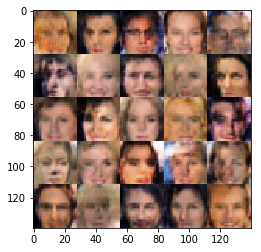

Epoch 1/1..., step 1510 Discriminator Loss: 1.2813... Generator Loss: 0.7830
Epoch 1/1..., step 1520 Discriminator Loss: 1.2028... Generator Loss: 1.1915
Epoch 1/1..., step 1530 Discriminator Loss: 1.2841... Generator Loss: 0.6712
Epoch 1/1..., step 1540 Discriminator Loss: 1.3737... Generator Loss: 0.8793
Epoch 1/1..., step 1550 Discriminator Loss: 1.4126... Generator Loss: 0.6684
Epoch 1/1..., step 1560 Discriminator Loss: 1.2724... Generator Loss: 0.7993
Epoch 1/1..., step 1570 Discriminator Loss: 1.2860... Generator Loss: 0.7180
Epoch 1/1..., step 1580 Discriminator Loss: 1.3667... Generator Loss: 0.7672
Epoch 1/1..., step 1590 Discriminator Loss: 1.2442... Generator Loss: 0.7253
Epoch 1/1..., step 1600 Discriminator Loss: 1.4547... Generator Loss: 0.7104


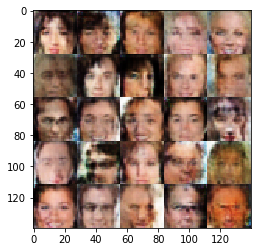

Epoch 1/1..., step 1610 Discriminator Loss: 1.4228... Generator Loss: 0.6712
Epoch 1/1..., step 1620 Discriminator Loss: 1.4364... Generator Loss: 0.7203
Epoch 1/1..., step 1630 Discriminator Loss: 1.2228... Generator Loss: 0.8765
Epoch 1/1..., step 1640 Discriminator Loss: 1.4438... Generator Loss: 0.7793
Epoch 1/1..., step 1650 Discriminator Loss: 1.2894... Generator Loss: 0.8443
Epoch 1/1..., step 1660 Discriminator Loss: 1.4381... Generator Loss: 0.7203
Epoch 1/1..., step 1670 Discriminator Loss: 1.3071... Generator Loss: 0.7768
Epoch 1/1..., step 1680 Discriminator Loss: 1.2815... Generator Loss: 0.8317
Epoch 1/1..., step 1690 Discriminator Loss: 1.3418... Generator Loss: 0.9128
Epoch 1/1..., step 1700 Discriminator Loss: 1.2468... Generator Loss: 0.8122


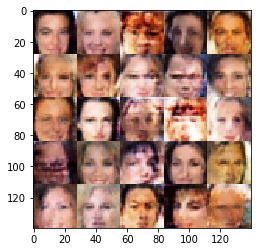

Epoch 1/1..., step 1710 Discriminator Loss: 1.4219... Generator Loss: 0.6180
Epoch 1/1..., step 1720 Discriminator Loss: 1.3031... Generator Loss: 0.8484
Epoch 1/1..., step 1730 Discriminator Loss: 1.3386... Generator Loss: 0.7989
Epoch 1/1..., step 1740 Discriminator Loss: 1.4142... Generator Loss: 0.9300
Epoch 1/1..., step 1750 Discriminator Loss: 1.2246... Generator Loss: 1.0738
Epoch 1/1..., step 1760 Discriminator Loss: 1.3684... Generator Loss: 0.9137
Epoch 1/1..., step 1770 Discriminator Loss: 1.3256... Generator Loss: 0.8282
Epoch 1/1..., step 1780 Discriminator Loss: 1.2397... Generator Loss: 1.0440
Epoch 1/1..., step 1790 Discriminator Loss: 1.3077... Generator Loss: 0.7473
Epoch 1/1..., step 1800 Discriminator Loss: 1.2488... Generator Loss: 1.0219


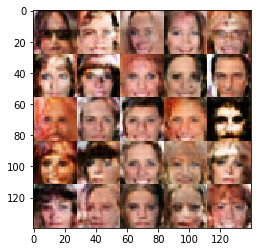

Epoch 1/1..., step 1810 Discriminator Loss: 1.4636... Generator Loss: 0.6106
Epoch 1/1..., step 1820 Discriminator Loss: 1.4333... Generator Loss: 0.7754
Epoch 1/1..., step 1830 Discriminator Loss: 1.3393... Generator Loss: 0.8306
Epoch 1/1..., step 1840 Discriminator Loss: 1.2887... Generator Loss: 0.8881
Epoch 1/1..., step 1850 Discriminator Loss: 1.3428... Generator Loss: 0.8513
Epoch 1/1..., step 1860 Discriminator Loss: 1.3729... Generator Loss: 0.8354
Epoch 1/1..., step 1870 Discriminator Loss: 1.3259... Generator Loss: 0.8155
Epoch 1/1..., step 1880 Discriminator Loss: 1.3700... Generator Loss: 1.0986
Epoch 1/1..., step 1890 Discriminator Loss: 1.2609... Generator Loss: 0.9838
Epoch 1/1..., step 1900 Discriminator Loss: 1.3542... Generator Loss: 0.9420


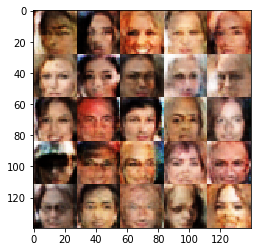

Epoch 1/1..., step 1910 Discriminator Loss: 1.3221... Generator Loss: 0.7189
Epoch 1/1..., step 1920 Discriminator Loss: 1.3759... Generator Loss: 0.7021
Epoch 1/1..., step 1930 Discriminator Loss: 1.2665... Generator Loss: 0.9345
Epoch 1/1..., step 1940 Discriminator Loss: 1.2597... Generator Loss: 0.9111
Epoch 1/1..., step 1950 Discriminator Loss: 1.5719... Generator Loss: 0.7364
Epoch 1/1..., step 1960 Discriminator Loss: 1.3050... Generator Loss: 0.6832
Epoch 1/1..., step 1970 Discriminator Loss: 1.3085... Generator Loss: 0.8398
Epoch 1/1..., step 1980 Discriminator Loss: 1.3130... Generator Loss: 0.7988
Epoch 1/1..., step 1990 Discriminator Loss: 1.2916... Generator Loss: 0.7382
Epoch 1/1..., step 2000 Discriminator Loss: 1.3978... Generator Loss: 0.9732


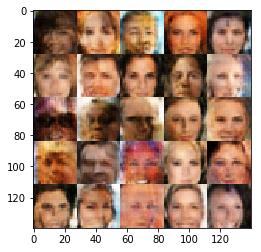

Epoch 1/1..., step 2010 Discriminator Loss: 1.3393... Generator Loss: 0.8606
Epoch 1/1..., step 2020 Discriminator Loss: 1.3822... Generator Loss: 0.5979
Epoch 1/1..., step 2030 Discriminator Loss: 1.2936... Generator Loss: 0.7169
Epoch 1/1..., step 2040 Discriminator Loss: 1.4169... Generator Loss: 0.7009
Epoch 1/1..., step 2050 Discriminator Loss: 1.4011... Generator Loss: 0.7913
Epoch 1/1..., step 2060 Discriminator Loss: 1.2670... Generator Loss: 0.7254
Epoch 1/1..., step 2070 Discriminator Loss: 1.3565... Generator Loss: 0.8647
Epoch 1/1..., step 2080 Discriminator Loss: 1.4207... Generator Loss: 0.5301
Epoch 1/1..., step 2090 Discriminator Loss: 1.3010... Generator Loss: 0.8046
Epoch 1/1..., step 2100 Discriminator Loss: 1.2148... Generator Loss: 1.0050


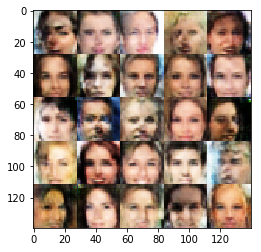

Epoch 1/1..., step 2110 Discriminator Loss: 1.3303... Generator Loss: 0.8189
Epoch 1/1..., step 2120 Discriminator Loss: 1.3720... Generator Loss: 0.8386
Epoch 1/1..., step 2130 Discriminator Loss: 1.3453... Generator Loss: 0.8431
Epoch 1/1..., step 2140 Discriminator Loss: 1.3217... Generator Loss: 0.7897
Epoch 1/1..., step 2150 Discriminator Loss: 1.3181... Generator Loss: 0.7045
Epoch 1/1..., step 2160 Discriminator Loss: 1.3693... Generator Loss: 0.7894
Epoch 1/1..., step 2170 Discriminator Loss: 1.2410... Generator Loss: 0.8816
Epoch 1/1..., step 2180 Discriminator Loss: 1.3559... Generator Loss: 0.8963
Epoch 1/1..., step 2190 Discriminator Loss: 1.4074... Generator Loss: 0.6685
Epoch 1/1..., step 2200 Discriminator Loss: 1.3137... Generator Loss: 0.8680


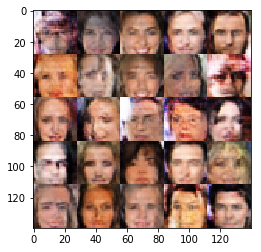

Epoch 1/1..., step 2210 Discriminator Loss: 1.3211... Generator Loss: 0.8217
Epoch 1/1..., step 2220 Discriminator Loss: 1.3003... Generator Loss: 0.7328
Epoch 1/1..., step 2230 Discriminator Loss: 1.6315... Generator Loss: 0.6043
Epoch 1/1..., step 2240 Discriminator Loss: 1.3117... Generator Loss: 0.8601
Epoch 1/1..., step 2250 Discriminator Loss: 1.2640... Generator Loss: 0.9168
Epoch 1/1..., step 2260 Discriminator Loss: 1.3123... Generator Loss: 0.8673
Epoch 1/1..., step 2270 Discriminator Loss: 1.3558... Generator Loss: 0.7744
Epoch 1/1..., step 2280 Discriminator Loss: 1.3234... Generator Loss: 0.7717
Epoch 1/1..., step 2290 Discriminator Loss: 1.2601... Generator Loss: 0.8650
Epoch 1/1..., step 2300 Discriminator Loss: 1.3798... Generator Loss: 0.7254


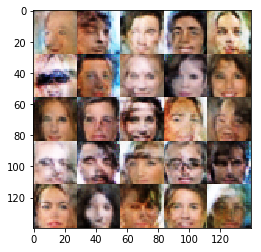

Epoch 1/1..., step 2310 Discriminator Loss: 1.2378... Generator Loss: 0.9656
Epoch 1/1..., step 2320 Discriminator Loss: 1.3666... Generator Loss: 0.9801
Epoch 1/1..., step 2330 Discriminator Loss: 1.3216... Generator Loss: 0.7212
Epoch 1/1..., step 2340 Discriminator Loss: 1.1765... Generator Loss: 1.0517
Epoch 1/1..., step 2350 Discriminator Loss: 1.3963... Generator Loss: 0.6782
Epoch 1/1..., step 2360 Discriminator Loss: 1.5137... Generator Loss: 0.5448
Epoch 1/1..., step 2370 Discriminator Loss: 1.2717... Generator Loss: 0.7656
Epoch 1/1..., step 2380 Discriminator Loss: 1.3175... Generator Loss: 0.8022
Epoch 1/1..., step 2390 Discriminator Loss: 1.2504... Generator Loss: 0.9976
Epoch 1/1..., step 2400 Discriminator Loss: 1.3887... Generator Loss: 0.9427


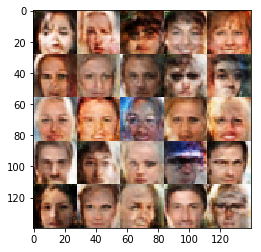

Epoch 1/1..., step 2410 Discriminator Loss: 1.3160... Generator Loss: 0.7263
Epoch 1/1..., step 2420 Discriminator Loss: 1.3941... Generator Loss: 0.7182
Epoch 1/1..., step 2430 Discriminator Loss: 1.2777... Generator Loss: 0.8331
Epoch 1/1..., step 2440 Discriminator Loss: 1.3065... Generator Loss: 0.9148
Epoch 1/1..., step 2450 Discriminator Loss: 1.2756... Generator Loss: 0.8251
Epoch 1/1..., step 2460 Discriminator Loss: 1.2538... Generator Loss: 0.9696
Epoch 1/1..., step 2470 Discriminator Loss: 1.3374... Generator Loss: 0.8152
Epoch 1/1..., step 2480 Discriminator Loss: 1.3567... Generator Loss: 0.7112
Epoch 1/1..., step 2490 Discriminator Loss: 1.3453... Generator Loss: 0.6756
Epoch 1/1..., step 2500 Discriminator Loss: 1.2282... Generator Loss: 1.0826


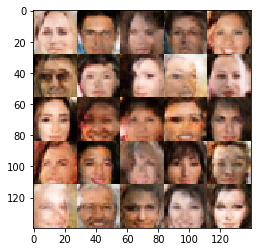

Epoch 1/1..., step 2510 Discriminator Loss: 1.3944... Generator Loss: 0.8488
Epoch 1/1..., step 2520 Discriminator Loss: 1.2902... Generator Loss: 0.7288
Epoch 1/1..., step 2530 Discriminator Loss: 1.4253... Generator Loss: 0.8438
Epoch 1/1..., step 2540 Discriminator Loss: 1.4623... Generator Loss: 0.6580
Epoch 1/1..., step 2550 Discriminator Loss: 1.2848... Generator Loss: 0.9816
Epoch 1/1..., step 2560 Discriminator Loss: 1.4108... Generator Loss: 0.5840
Epoch 1/1..., step 2570 Discriminator Loss: 1.4049... Generator Loss: 0.7606
Epoch 1/1..., step 2580 Discriminator Loss: 1.3482... Generator Loss: 0.8758
Epoch 1/1..., step 2590 Discriminator Loss: 1.3310... Generator Loss: 0.7524
Epoch 1/1..., step 2600 Discriminator Loss: 1.1944... Generator Loss: 1.0332


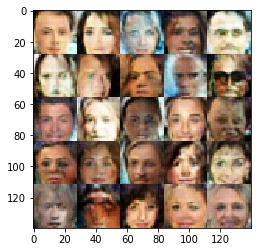

Epoch 1/1..., step 2610 Discriminator Loss: 1.4473... Generator Loss: 0.5969
Epoch 1/1..., step 2620 Discriminator Loss: 1.4043... Generator Loss: 0.7267
Epoch 1/1..., step 2630 Discriminator Loss: 1.3038... Generator Loss: 0.7551
Epoch 1/1..., step 2640 Discriminator Loss: 1.2561... Generator Loss: 0.8958
Epoch 1/1..., step 2650 Discriminator Loss: 1.2961... Generator Loss: 0.7197
Epoch 1/1..., step 2660 Discriminator Loss: 1.3481... Generator Loss: 0.8072
Epoch 1/1..., step 2670 Discriminator Loss: 1.3171... Generator Loss: 0.9613
Epoch 1/1..., step 2680 Discriminator Loss: 1.3735... Generator Loss: 0.8478
Epoch 1/1..., step 2690 Discriminator Loss: 1.3257... Generator Loss: 0.6809
Epoch 1/1..., step 2700 Discriminator Loss: 1.3281... Generator Loss: 0.8372


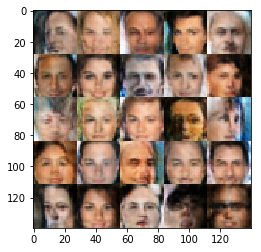

Epoch 1/1..., step 2710 Discriminator Loss: 1.3455... Generator Loss: 0.8995
Epoch 1/1..., step 2720 Discriminator Loss: 1.3175... Generator Loss: 0.8949
Epoch 1/1..., step 2730 Discriminator Loss: 1.3750... Generator Loss: 0.6892
Epoch 1/1..., step 2740 Discriminator Loss: 1.3001... Generator Loss: 0.7896
Epoch 1/1..., step 2750 Discriminator Loss: 1.2080... Generator Loss: 0.9440
Epoch 1/1..., step 2760 Discriminator Loss: 1.3442... Generator Loss: 0.7726
Epoch 1/1..., step 2770 Discriminator Loss: 1.2108... Generator Loss: 0.8391
Epoch 1/1..., step 2780 Discriminator Loss: 1.2707... Generator Loss: 0.8006
Epoch 1/1..., step 2790 Discriminator Loss: 1.3359... Generator Loss: 0.8961
Epoch 1/1..., step 2800 Discriminator Loss: 1.2004... Generator Loss: 0.9242


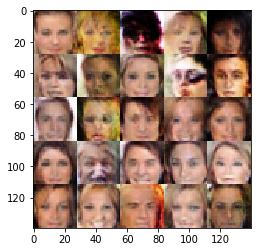

Epoch 1/1..., step 2810 Discriminator Loss: 1.3371... Generator Loss: 0.9647
Epoch 1/1..., step 2820 Discriminator Loss: 1.4101... Generator Loss: 0.7835
Epoch 1/1..., step 2830 Discriminator Loss: 1.3396... Generator Loss: 0.8090
Epoch 1/1..., step 2840 Discriminator Loss: 1.2984... Generator Loss: 0.8016
Epoch 1/1..., step 2850 Discriminator Loss: 1.3003... Generator Loss: 0.8241
Epoch 1/1..., step 2860 Discriminator Loss: 1.3316... Generator Loss: 0.7099
Epoch 1/1..., step 2870 Discriminator Loss: 1.1543... Generator Loss: 0.9306
Epoch 1/1..., step 2880 Discriminator Loss: 1.3264... Generator Loss: 0.8571
Epoch 1/1..., step 2890 Discriminator Loss: 1.3437... Generator Loss: 0.7618
Epoch 1/1..., step 2900 Discriminator Loss: 1.2451... Generator Loss: 0.8686


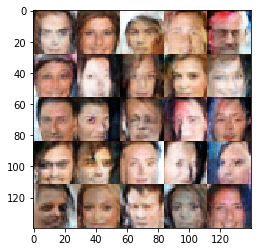

Epoch 1/1..., step 2910 Discriminator Loss: 1.2809... Generator Loss: 0.8761
Epoch 1/1..., step 2920 Discriminator Loss: 1.2906... Generator Loss: 0.7469
Epoch 1/1..., step 2930 Discriminator Loss: 1.3082... Generator Loss: 0.7807
Epoch 1/1..., step 2940 Discriminator Loss: 1.3336... Generator Loss: 0.6863
Epoch 1/1..., step 2950 Discriminator Loss: 1.4105... Generator Loss: 0.6293
Epoch 1/1..., step 2960 Discriminator Loss: 1.5283... Generator Loss: 0.5878
Epoch 1/1..., step 2970 Discriminator Loss: 1.3075... Generator Loss: 0.7690
Epoch 1/1..., step 2980 Discriminator Loss: 1.4812... Generator Loss: 0.7493
Epoch 1/1..., step 2990 Discriminator Loss: 1.3345... Generator Loss: 0.9115
Epoch 1/1..., step 3000 Discriminator Loss: 1.4188... Generator Loss: 0.7011


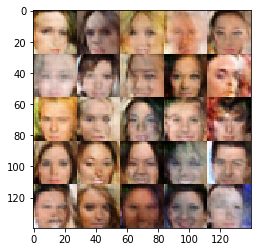

Epoch 1/1..., step 3010 Discriminator Loss: 1.2457... Generator Loss: 0.8722
Epoch 1/1..., step 3020 Discriminator Loss: 1.2334... Generator Loss: 1.2900
Epoch 1/1..., step 3030 Discriminator Loss: 1.3218... Generator Loss: 0.8274
Epoch 1/1..., step 3040 Discriminator Loss: 1.2460... Generator Loss: 0.8242
Epoch 1/1..., step 3050 Discriminator Loss: 1.3565... Generator Loss: 0.8213
Epoch 1/1..., step 3060 Discriminator Loss: 1.2986... Generator Loss: 0.7977
Epoch 1/1..., step 3070 Discriminator Loss: 1.1793... Generator Loss: 0.9562
Epoch 1/1..., step 3080 Discriminator Loss: 1.3059... Generator Loss: 0.8666
Epoch 1/1..., step 3090 Discriminator Loss: 1.3066... Generator Loss: 0.8473
Epoch 1/1..., step 3100 Discriminator Loss: 1.3415... Generator Loss: 0.8974


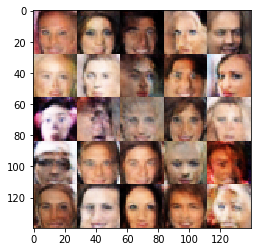

Epoch 1/1..., step 3110 Discriminator Loss: 1.3815... Generator Loss: 0.7137
Epoch 1/1..., step 3120 Discriminator Loss: 1.3827... Generator Loss: 0.6740
Epoch 1/1..., step 3130 Discriminator Loss: 1.2878... Generator Loss: 0.9653
Epoch 1/1..., step 3140 Discriminator Loss: 1.2232... Generator Loss: 0.8690
Epoch 1/1..., step 3150 Discriminator Loss: 1.4059... Generator Loss: 0.7205
Epoch 1/1..., step 3160 Discriminator Loss: 1.3831... Generator Loss: 0.7026


In [15]:
batch_size = 64
z_dim = 100
learning_rate = 0.0004
beta1 = 0.5

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.